In [1]:
from math import atan, cos, sin, tan
import sys
import typing

import torch
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import omegaconf

import radon

from ellipses_datamodule import EllipsesDataModule

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7'


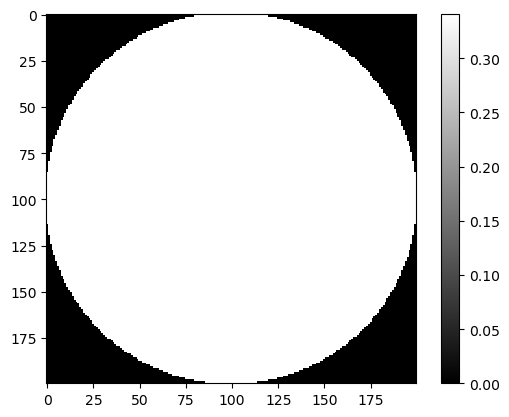

In [2]:
#pyright: reportGeneralTypeIssues=false
def gen_ellipses(img_size: int, ellipses_count: int, ellipses_size: float, ellipses_size_min: float=1) -> torch.Tensor:
    fig = plt.figure(figsize=(img_size,img_size), dpi=1)
    ax = fig.add_axes([0.0,0.0,1.0,1.0])
    ellipse_func = lambda w, h, a, t: (w/2.0*cos(t)*cos(a)-h/2.0*sin(t)*sin(a), w/2.0*cos(t)*sin(a)+h/2.0*sin(t)*cos(a))
    for _ in range(ellipses_count):
        ellipse_width_aa = np.random.rand()*max(0.0, ellipses_size-ellipses_size_min)+ellipses_size_min
        ellipse_height_aa = np.random.rand()*max(0.0, ellipses_size-ellipses_size_min)+ellipses_size_min
        ellipse_angle = np.random.rand()*360.0
        args = (ellipse_width_aa, ellipse_height_aa, ellipse_angle/180.0*np.pi)
        t = atan(-ellipse_height_aa*tan(ellipse_angle/180.0*np.pi)/ellipse_width_aa)
        ellipse_width = max(ellipse_func(*args, t)[0], ellipse_func(*args, t+np.pi)[0])-min(ellipse_func(*args, t)[0], ellipse_func(*args, t+np.pi)[0])
        t = atan(ellipse_height_aa/(tan(ellipse_angle/180.0*np.pi)*ellipse_width_aa))
        ellipse_height = max(ellipse_func(*args, t)[1], ellipse_func(*args, t+np.pi)[1])-min(ellipse_func(*args, t)[1], ellipse_func(*args, t+np.pi)[1])
        ellipse_x = ellipse_width/2.0+np.random.rand()*(img_size-ellipse_width)
        ellipse_y = ellipse_height/2.0+np.random.rand()*(img_size-ellipse_height)
        ellipse = matplotlib.patches.Ellipse(xy=[ellipse_x, ellipse_y], width=ellipse_width_aa, height=ellipse_height_aa, angle=ellipse_angle)
        ax.add_artist(ellipse)
        ellipse.set_clip_box(ax.bbox)
        ellipse.set_alpha(0.1+0.9*np.random.rand())
        ellipse.set_facecolor("black")
        ellipse.set_edgecolor(None)
        ellipse.set_antialiased(False)
    ax.axis("off")
    ax.set_xlim(0.0, img_size)
    ax.set_ylim(0.0, img_size)
    fig.add_axes(ax)
    fig.canvas.draw()
    img = torch.from_numpy(np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).copy())
    if sys.platform == "win32":
        img = 1.0-torch.swapaxes(img.reshape(img_size,img_size,4), 0, 2).to(torch.float32)[3:4]/255.0
    else:
        img = torch.swapaxes(img.reshape(img_size,img_size,4), 0, 2).to(torch.float32)[0:1]/255.0
    plt.close()
    return img

plt.figure()
plt.imshow(gen_ellipses(200, 1, 200, 200)[0], interpolation="none", cmap="gray")
plt.colorbar()
plt.show()

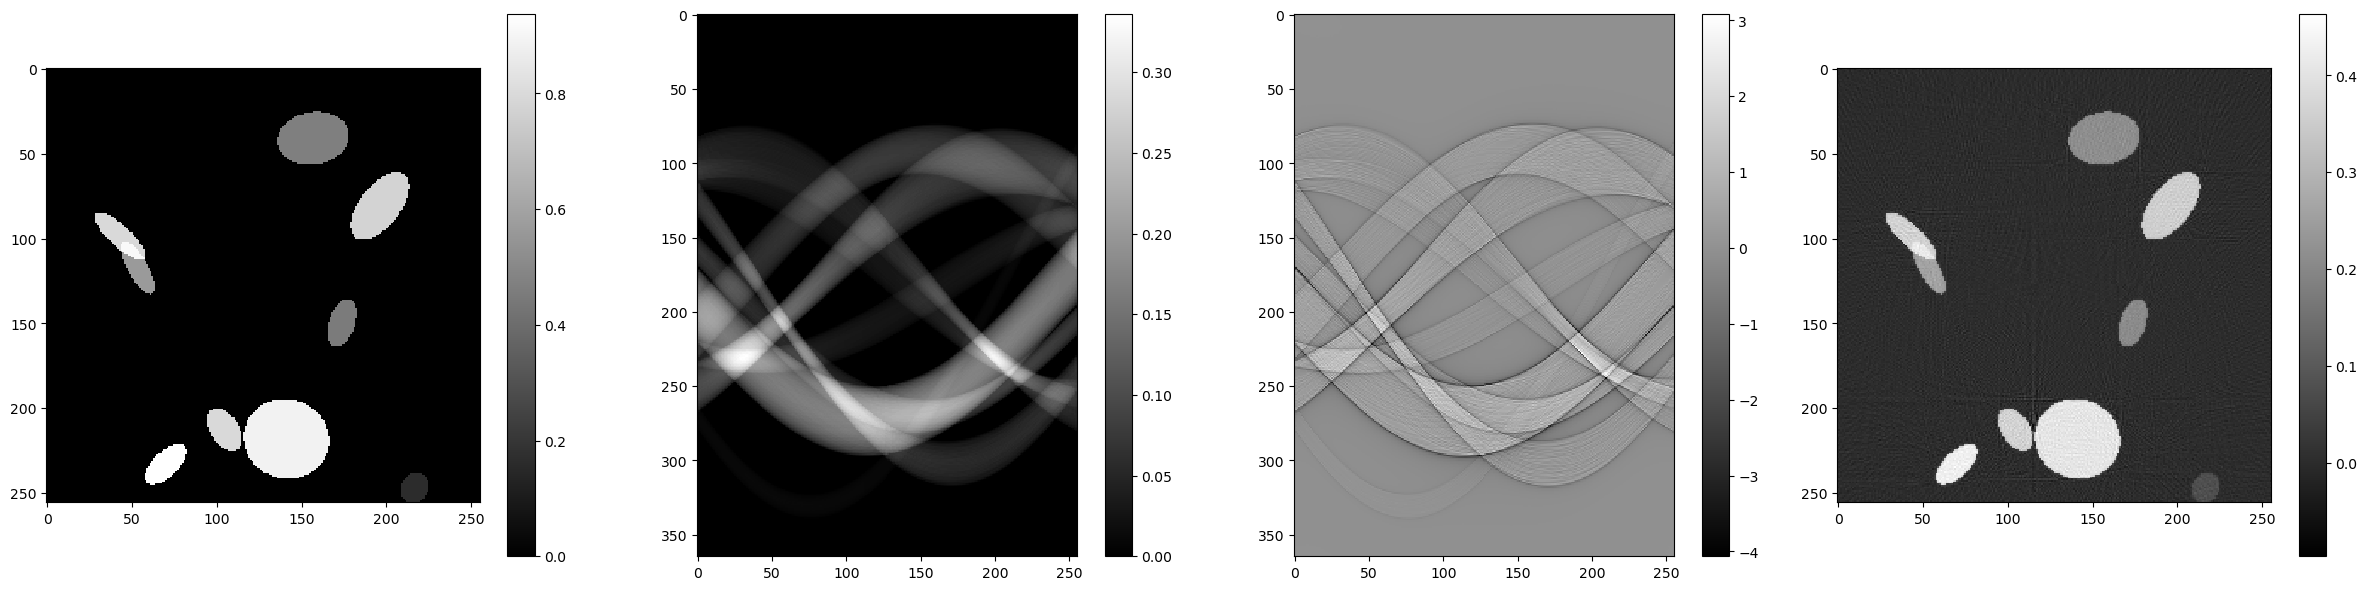

In [4]:
torch.manual_seed(123)
tdmi = iter(EllipsesDataModule(typing.cast(omegaconf.DictConfig, type("",(object,), {
    "img_size": 256, 
    "training_batch_count": -1, 
    "training_batch_size": 32, 
    "drop_last_training_batch": True, 
    "shuffle_training_data": False, 
    "num_workers": 0,
    "ellipse_count": 10,
    "ellipse_size": 50,
    "ellipse_size_min": 10
})())).train_dataloader())
plt.subplots(1,4,figsize=(24,6))
plt.subplot(1,4,1)
img = next(tdmi)
plt.imshow(img[0,0], interpolation="nearest", cmap="gray")
plt.colorbar()
plt.subplot(1,4,2)
sino = radon.radon_forward(img)
plt.imshow(sino[0,0].mT, interpolation="nearest", cmap="gray")
plt.colorbar()
plt.subplot(1,4,3)
fsino = radon.radon_filter(sino, radon.ram_lak_filter)
plt.imshow(fsino[0,0].mT, interpolation="nearest", cmap="gray")
plt.colorbar()
plt.subplot(1,4,4)
recon = radon.radon_backward(fsino, 256)
plt.imshow(recon[0,0], interpolation="nearest", cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()